### Setup Model

In [1]:
import torch, requests, math
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration, BitsAndBytesConfig

c:\Users\namth\anaconda3\envs\lung_caption_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1006 10:59:51.897000 20968 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# ----------------------------
# 0) เตรียมอุปกรณ์
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
# ----------------------------
# 1) โหลดโมเดล + โปรเซสเซอร์
# ----------------------------

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
)

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
    quantization_config=bnb_cfg,
    device_map={"": 0},                 # <<< บังคับลง GPU0 ทั้งโมเดล
    low_cpu_mem_usage=True,
    dtype=torch.bfloat16,         # ให้ตรงกับ compute_dtype ด้านบน
    output_attentions=True,
    output_hidden_states=True
    # ไม่ใส่ offload_folder
).eval().cuda()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]


In [6]:
# ----------------------------
# 2) โหลดภาพทดสอบ + คำสั่ง
# ----------------------------

# url = "https://radiologybusiness.com/sites/default/files/assets/articles/4996132.jpg"
# image = Image.open(BytesIO(requests.get(url, timeout=15).content)).convert("RGB").resize((224, 224))

file_path = "./progress_picture/2nd/qwen/1/Original.jpg"

# เปิดไฟล์จาก local
image = Image.open(file_path).convert("RGB").resize((224, 224))

messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": "Describe this image."}
    ],
}]

In [7]:
# ----------------------------
# 3) Inference ให้เห็นผลข้อความจริง
# ----------------------------

chat_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# สร้าง batch inputs (ทั้งข้อความ+ภาพ) สำหรับ generate
inputs = processor(
    text=[chat_text],
    images=[image],
    videos=None,
    padding=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.inference_mode():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=24,
        do_sample=False,        # deterministic
        use_cache=True,
    )

# ตัด prompt ออก เหลือเฉพาะที่โมเดลพูดต่อ
trimmed = [out[len(inp):] for inp, out in zip(inputs["input_ids"], gen_ids)]
texts = processor.batch_decode(trimmed, skip_special_tokens=True)
print("Model output:", texts[0].strip())

The following generation flags are not valid and may be ignored: ['temperature', 'output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model output: This image is an X-ray of the chest, which is commonly used to examine the lungs and other structures in the thor


1) Model output: This image is an X-ray of the chest, which is commonly used to examine
2) Model output: This image is a chest X-ray, which is used to examine the lungs and
3) Model output: This image is an X-ray of the chest, which is commonly used to diagnose
4) Model output: The image shows a cat with a distinctive orange coat and a black mask around its
5) Model output: The image depicts a body of water with gentle waves and ripples. The water

### Visualize Feature Map BUT Attention layer

In [19]:
# ---------- Utilities to locate visual/text token spans for Qwen2.5-VL (multi <|image_pad|>) ----------
import torch

def get_special_token_ids(processor):
    tok = processor.tokenizer
    return {
        "vision_start": tok.convert_tokens_to_ids("<|vision_start|>"),
        "image_pad":    tok.convert_tokens_to_ids("<|image_pad|>"),
        "vision_end":   tok.convert_tokens_to_ids("<|vision_end|>"),
        "im_start":     tok.convert_tokens_to_ids("<|im_start|>"),
        "im_end":       tok.convert_tokens_to_ids("<|im_end|>"),
    }

@torch.no_grad()
def locate_visual_spans_multi(inputs, out_attentions, processor):
    """
    รองรับหลาย <|image_pad|> (เช่น 64 ตัว) ใน sequence เดียว
    คืนค่า:
        - spans: [(start_img, end_img), ...] ต่อ placeholder ตามลำดับซ้าย->ขวา หลัง forward
        - V_per_pad: จำนวนโทเคนภาพจริง/placeholder (คาดว่าเท่ากันทุกตัว)
        - pre_len, post_len, idx_vpads (ดัชนีก่อน forward)
        - groups: รายการกลุ่มต่อบล็อกภาพ (คอนทiguous pads) เช่น [(0,63)] สำหรับ 64 ตัวติดกัน
    หมายเหตุ: สมมติ batch=1 และภาพเดียวที่ถูกแตกเป็นหลาย placeholder
    """
    assert "input_ids" in inputs, "inputs must contain input_ids"
    input_ids = inputs["input_ids"][0]                  # (pre_len,)
    pre_len = input_ids.shape[0]
    post_len = out_attentions[0].shape[-1]              # (B, H, T, T) -> T

    ids = get_special_token_ids(processor)
    idx_vpads = (input_ids == ids["image_pad"]).nonzero(as_tuple=True)[0].tolist()
    if len(idx_vpads) == 0:
        raise ValueError("No <|image_pad|> found in input_ids.")

    N = len(idx_vpads)                                   # จำนวน placeholders
    # โทเคนภาพจริงรวมทั้งหมดหลัง forward:
    V_total = post_len - pre_len + N                     # แทนแต่ละ pad (1 โทเคนก่อน forward) ด้วย V_per_pad
    if V_total <= 0:
        raise ValueError(f"Invalid V_total computed: {V_total}")

    # สมมติว่าแต่ละ placeholder ขยายเป็นจำนวนโทเคนเท่ากัน:
    V_per_pad, remainder = divmod(V_total, N)

    # คำนวณ start/end ของแต่ละ placeholder หลัง forward
    # หลักการ: pad ลำดับ k (0-based) จะถูกเลื่อนขวาไปด้วย (V_per_pad-1) ต่อ pad ที่มาก่อน
    # ถ้ามี remainder>0 ให้แจก +1 กับ pads แรก ๆ ตามลำดับเพื่อให้ผลรวมตรง post_len
    spans = []
    extra_prefix = 0
    for k, ppre in enumerate(sorted(idx_vpads)):
        extra = 1 if k < remainder else 0                # แจกส่วนเกินทีละ 1 ไปทางซ้ายก่อน
        # จำนวนที่ขยายก่อนหน้ารวม:
        expanded_before = k * (V_per_pad - 1) + min(k, remainder)  # เพราะ k ตัวแรกได้ +1 เพิ่ม
        start_k = ppre + expanded_before
        end_k   = start_k + (V_per_pad + extra) - 1
        spans.append((start_k, end_k))

    # จัดกลุ่ม placeholder ที่ติดกัน (เผื่อคุณอยากขีดเป็นบล็อกเดียว)
    groups = []
    if idx_vpads:
        run_start = 0
        for i in range(1, N):
            if idx_vpads[i] != idx_vpads[i-1] + 1:
                groups.append((run_start, i-1))
                run_start = i
        groups.append((run_start, N-1))

    return {
        "spans": spans,                   # รายการช่วงภาพจริง ต่อ placeholder หลัง forward
        "V_per_pad": V_per_pad,
        "remainder": remainder,
        "pre_len": pre_len,
        "post_len": post_len,
        "idx_vpads": idx_vpads,          # ดัชนี <|image_pad|> ก่อน forward
        "groups": groups,                 # กลุ่มต่อบล็อกภาพ: index ใน idx_vpads เช่น [(0,63)]
        "N_pads": N,
        "V_total": V_total,
    }

def annotate_axes_with_span(ax, start_img, end_img, color='r', lw=1.2):
    ax.axvline(start_img - 0.5, linewidth=lw, color=color)
    ax.axvline(end_img   + 0.5, linewidth=lw, color=color)
    ax.axhline(start_img - 0.5, linewidth=lw, color=color)
    ax.axhline(end_img   + 0.5, linewidth=lw, color=color)


In [20]:
# ----------------------------
# 4) ดึง Visual Attention จาก Vision Tower (ViT)
#    - ใช้พิกเซลจาก image_processor โดยตรง
#    - ขอ output_attentions=True เพื่อดึงแผนที่ attention ทุกเลเยอร์
# ----------------------------

with torch.inference_mode():
    out = model(
        **inputs,
        output_attentions=True,
        return_dict=True,
        use_cache=False
    )

attentions = out.attentions

# ----------------------------
# คำนวณช่วงโทเคนภาพ/ข้อความเพื่ออ้างอิงตอน plot
# ----------------------------
span_info = locate_visual_spans_multi(inputs, attentions, processor)
print(f"[DEBUG] pre={span_info['pre_len']} post={span_info['post_len']} "
        f"N_pads={span_info['N_pads']} V_total={span_info['V_total']} "
        f"V_per_pad≈{span_info['V_per_pad']} remainder={span_info['remainder']}")

# ตัวอย่าง spans 3 ตัวแรก
print("[DEBUG] first 3 spans:", span_info["spans"][:3])

# Var
layer_idx_list = [0, 15, 35]

[DEBUG] pre=89 post=89 N_pads=64 V_total=64 V_per_pad≈1 remainder=0
[DEBUG] first 3 spans: [(15, 15), (16, 16), (17, 17)]


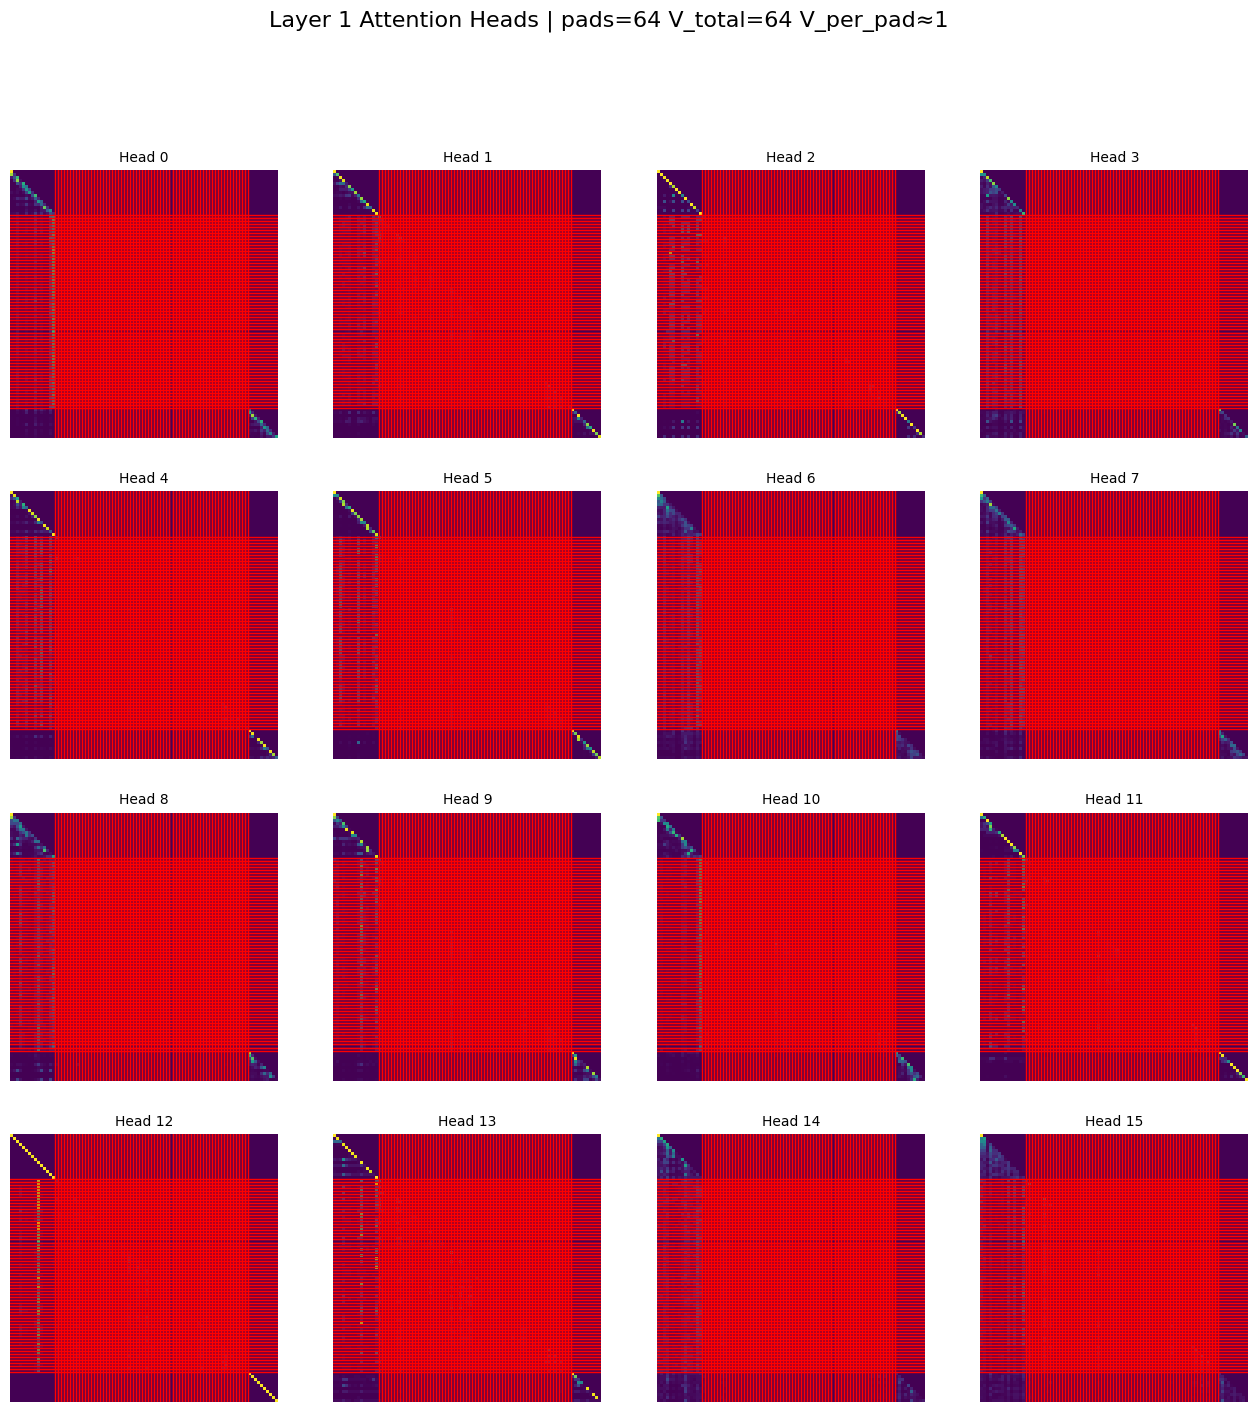

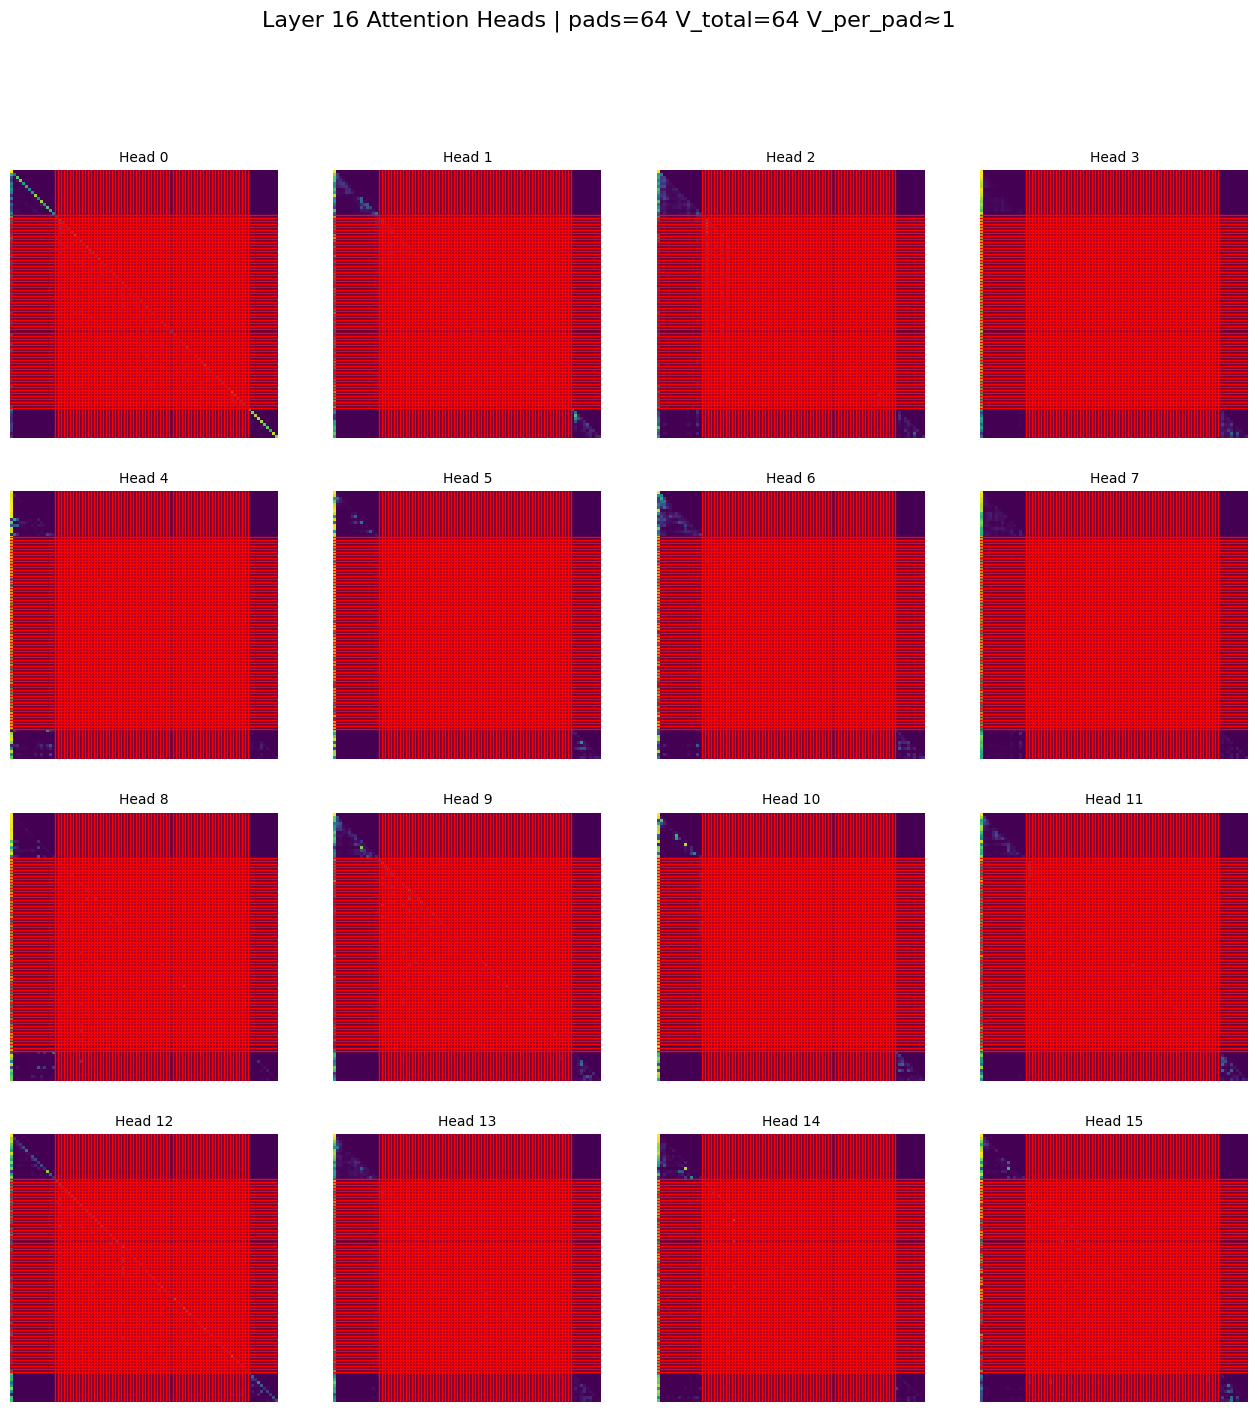

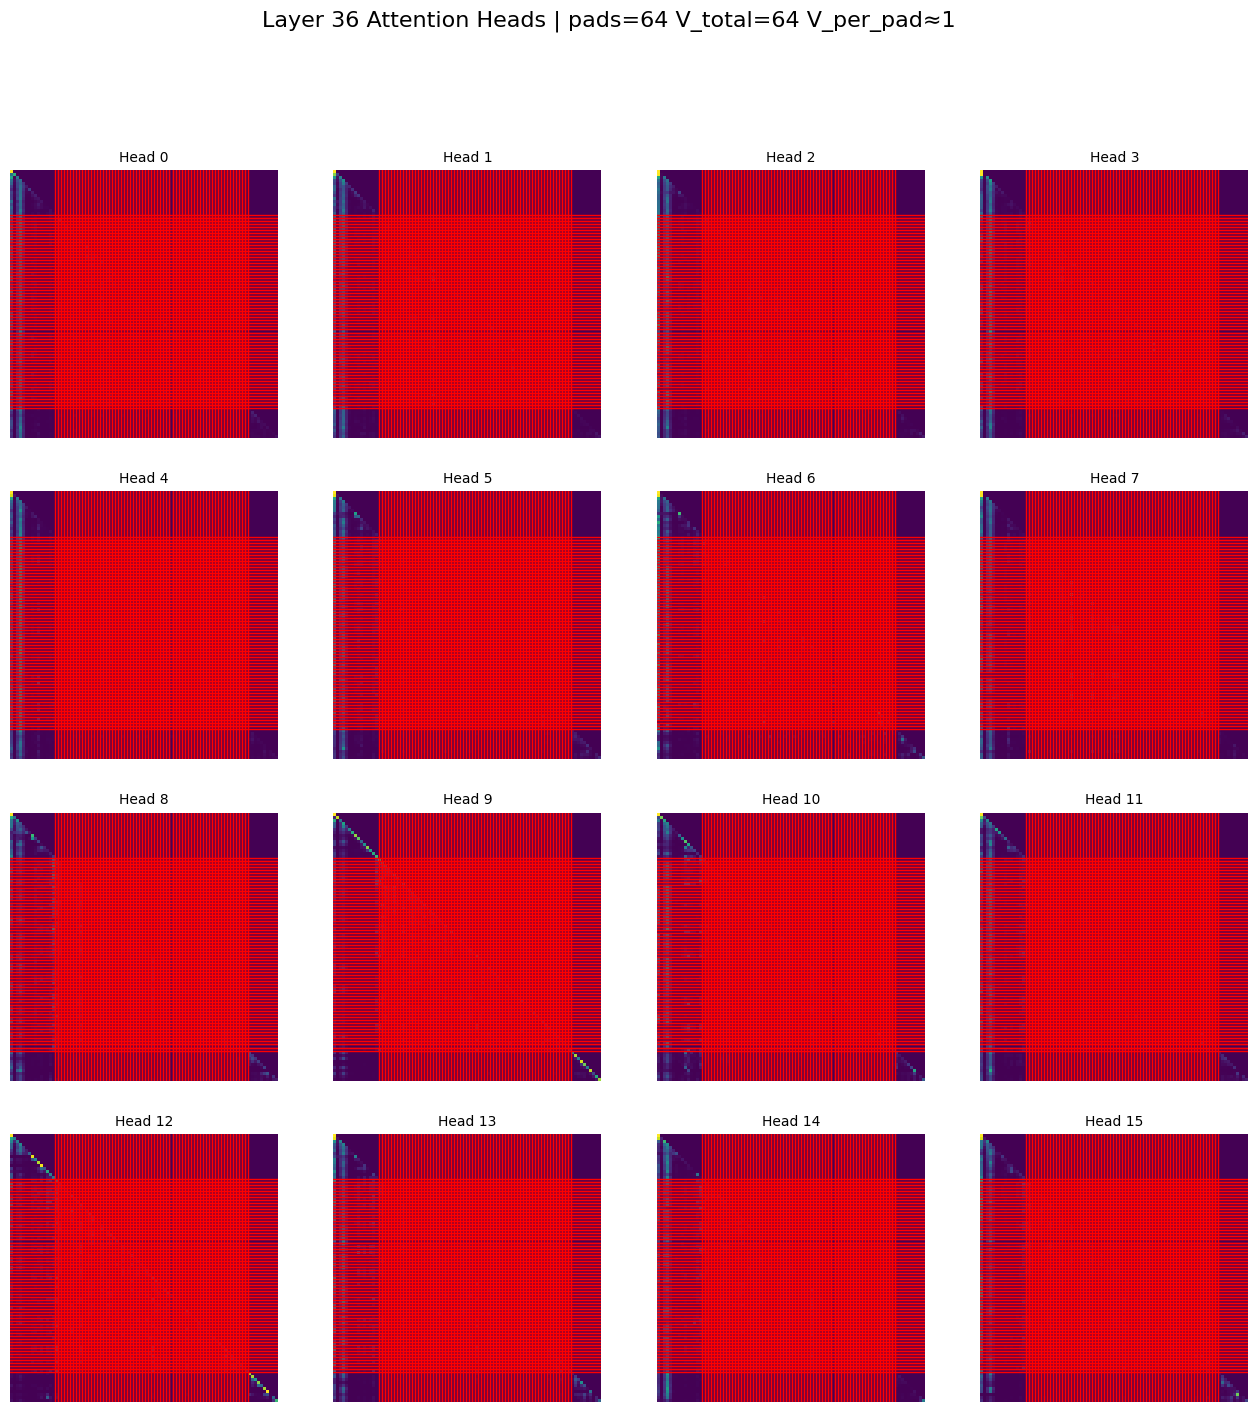

In [21]:
def visualize_attention_layer(attentions, layer_idx: int, nrows: int = 4, ncols: int = 4, span_info=None):
    layer = attentions[layer_idx]   # (batch, heads, T, T)
    batch0 = layer[0]

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < batch0.shape[0]:
            attn_head = batch0[i].detach().to("cpu", dtype=torch.float32).numpy()
            ax.imshow(attn_head)

            # ขีดกรอบช่วงภาพจริงทั้งหมด
            if span_info is not None:
                for (s, e) in span_info["spans"]:
                    annotate_axes_with_span(ax, s, e, color='r', lw=1.0)

            ax.set_title(f"Head {i}", fontsize=10)
        ax.axis("off")

    ttl = f"Layer {layer_idx + 1} Attention Heads"
    if span_info is not None:
        ttl += f" | pads={span_info['N_pads']} V_total={span_info['V_total']} V_per_pad≈{span_info['V_per_pad']}"
    plt.suptitle(ttl, fontsize=16)
    plt.savefig(f"Attention Heads Layer {layer_idx + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()

for i in layer_idx_list:
    visualize_attention_layer(attentions, i, span_info=span_info)

ความยาวโทเคนทั้งหมด

In [40]:
post_len = attentions[0].shape[-1]      # ความยาวแกน T ของ attention หลัง forward
pre_len  = inputs["input_ids"].shape[1] # ความยาวอินพุตก่อน forward
print("pre_len:", pre_len, "post_len:", post_len)

pre_len: 89 post_len: 89


span_info ไม่ใช่ค่าว่าง แต่เป็น “พจนานุกรมของตัวคั่น/ช่วง” ที่เราคำนวณไว้เพื่อรู้ว่า ช่วงใดคือโทเคนภาพ (หลัง forward) และช่วงที่เหลือคือ โทเคนข้อความ คุณใช้มันเพื่อขีดเส้นแบ่งบนฮีตแมป และเพื่อสร้าง mask แยกภาพ/ข้อความได้

In [ ]:
print(span_info["spans"][:3])

[(15, 15), (16, 16), (17, 17)]


In [43]:
start_indices = [s for (s, e) in span_info["spans"]]
print(start_indices[0])
print(start_indices[-1])

15
78


สร้าง mask แยก “ภาพ” กับ “ข้อความ” ใน post space

In [47]:
is_visual = np.zeros(post_len, dtype=bool)
for s, e in span_info["spans"]:
    is_visual[s:e+1] = True

# ข้อความ = ไม่ใช่ภาพ
is_text = ~is_visual

print(is_text)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True]


ถอดรหัสข้อความจากช่วง index ใน post space

In [ ]:
def build_post2pre_index_map(span_info, pre_len, post_len):
    """
    คืนอาเรย์ความยาว post_len ที่ชี้ไปยัง index ก่อน forward (pre index)
    สำหรับช่องที่เป็นโทเคนภาพ (post) จะให้ค่า -1 (ไม่มี pre id ให้ decode)
    """
    post2pre = np.full(post_len, -1, dtype=int)

    # เตรียมข้อมูลช่วย: ตำแหน่ง <|image_pad|> ก่อน forward (เรียงจากซ้ายไปขวา)
    pads_pre = sorted(span_info["idx_vpads"])              # ความยาว = N_pads
    spans = span_info["spans"]                             # รายการ (start_post, end_post) ต่อ pad
    # ทำ pointer เดินไปตามลำดับ pre/post
    # 1) mark ช่วงภาพใน post เป็น -1 (ไม่มี pre id)
    for (s, e) in spans:
        # ทั้งช่วงภาพไม่มี pre id โดยนิยาม (ถูก inject)
        pass  # post2pre[s:e+1] คงเป็น -1 อยู่แล้ว

    # 2) เติม mapping ให้โทเคน "ข้อความ" โดยเลื่อนตามจำนวนขยายก่อนหน้า
    # สร้าง offset function: จำนวนโทเคนภาพที่ถูก “สอดแทรก” ก่อนตำแหน่ง pre ที่กำหนด
    # (ใช้สูตรเดียวกับที่คำนวณ spans)
    # เพื่อความง่าย เราจะเดิน pre_idx จาก 0..pre_len-1 แล้วคำนวณ post_idx ที่มันไปอยู่
    V_per_pad = span_info["V_per_pad"]
    remainder = span_info["remainder"]     # pads แรก ๆ ที่ได้ +1
    pads_set = set(pads_pre)

    def expanded_before(k):  # k = ลำดับ pad (0-based) ก่อนหน้า
        return k * (V_per_pad - 1) + min(k, remainder)

    # สร้าง mapping pre→post
    pad_order = {p: i for i, p in enumerate(pads_pre)}  # pre_index ของ pad → ลำดับ pad
    extra_shift = 0
    post_cursor = 0
    pre_cursor = 0
    while pre_cursor < pre_len and post_cursor < post_len:
        if pre_cursor in pads_set:
            # เจอ pad ณ pre_cursor: ข้ามมัน (เพราะจะถูกแทนด้วยภาพใน post)
            k = pad_order[pre_cursor]
            # กระโดด post_cursor ไปท้ายช่วงภาพของ pad นี้
            s, e = spans[k]
            post_cursor = e + 1
            pre_cursor += 1
        else:
            # โทเคนข้อความ: หา post index ที่สอดคล้อง
            # นับจำนวน pad ที่อยู่ทางซ้ายของ pre_cursor
            # คือจำนวน p ใน pads_pre ที่ < pre_cursor
            k_left = np.searchsorted(pads_pre, pre_cursor, side="left")
            shift = expanded_before(k_left)  # จำนวนโทเคนเพิ่มจากภาพที่ขยายไปแล้ว
            post_idx = pre_cursor + shift
            if 0 <= post_idx < post_len and post2pre[post_idx] == -1:
                post2pre[post_idx] = pre_cursor
            pre_cursor += 1
            # ไม่ต้องขยับ post_cursor เพราะเราจัดการแบบคำนวณตำแหน่งโดยตรง

    return post2pre

post2pre = build_post2pre_index_map(span_info, pre_len, post_len)

In [52]:
post2pre

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88])

In [51]:
from transformers import PreTrainedTokenizerBase

tok = processor.tokenizer  # type: PreTrainedTokenizerBase

def decode_text_from_post_indices(post_indices, post2pre, inputs, tokenizer, skip_special=True):
    pre_indices = [post2pre[i] for i in post_indices if 0 <= post2pre[i] < inputs["input_ids"].shape[1]]
    if not pre_indices:
        return ""
    ids = inputs["input_ids"][0, pre_indices].tolist()
    return tokenizer.decode(ids, skip_special_tokens=skip_special)

# ตัวอย่าง: decode ข้อความ "ก่อนช่วงภาพแรก" (ถ้ามี)
text_left = None
first_span = min(span_info["spans"], key=lambda x: x[0])
if first_span[0] > 0:
    post_idx_range = list(range(0, first_span[0]))                       # [0 .. start_img-1]
    post_idx_range = [i for i in post_idx_range if post2pre[i] != -1]    # ตัดภาพทิ้ง
    text_left = decode_text_from_post_indices(post_idx_range, post2pre, inputs, tok)
    print("Decoded (left of first image):", text_left)

# หรือ decode “ทั้งหมดที่เป็นข้อความ” ใน post space
all_text_post_idx = [i for i in range(post_len) if post2pre[i] != -1]
decoded_all = decode_text_from_post_indices(all_text_post_idx, post2pre, inputs, tok)
print("Decoded (all text tokens from prompt):", decoded_all)

Decoded (left of first image): system
You are a helpful assistant.
user

Decoded (all text tokens from prompt): system
You are a helpful assistant.
user
Describe this image.
assistant



In [65]:
attentions = out.attentions     # tuple(L) ของ tensor (B, H, T, T)
layer_idx = 10                  # เลือกเลเยอร์
batch_idx = 0                   # สมมติ batch เดียว
head_idx  = 3                   # เลือกหัว
token_idx = 16                 # index ของโทเคนที่อยากดู

In [66]:
attn = attentions[layer_idx][batch_idx, head_idx]   # (T, T)
weights = attn[token_idx]                           # shape (T,)
print(weights.shape)
print("Sum =", weights.sum().item())                # ควร ≈ 1.0

torch.Size([89])
Sum = 1.0


In [67]:
topk = torch.topk(weights, k=10)
print("Top attention targets:", topk.indices.tolist())
print("Weights:", topk.values.tolist())

Top attention targets: [0, 16, 13, 15, 10, 7, 14, 2, 6, 5]
Weights: [0.890625, 0.044189453125, 0.0186767578125, 0.0101318359375, 0.007415771484375, 0.004730224609375, 0.004425048828125, 0.0032501220703125, 0.00286865234375, 0.00244140625]


In [68]:
weights_col = attn[:, token_idx]   # shape (T,)
topk = torch.topk(weights_col, k=10)
print("Most queries attending to token 120:", topk.indices.tolist())

Most queries attending to token 120: [45, 37, 44, 16, 42, 39, 27, 63, 17, 23]


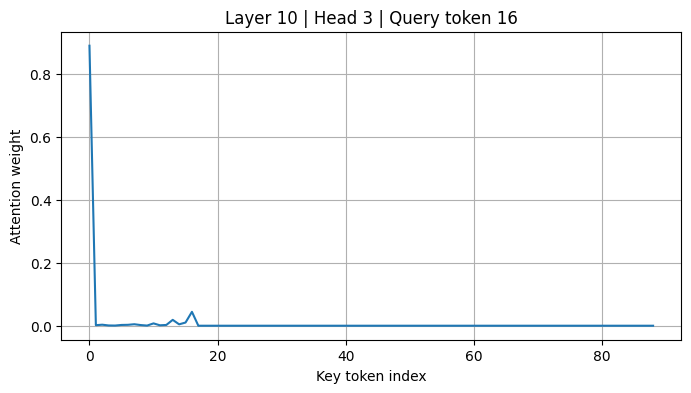

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(weights.detach().to('cpu', dtype=torch.float32).numpy())
plt.title(f"Layer {layer_idx} | Head {head_idx} | Query token {token_idx}")
plt.xlabel("Key token index")
plt.ylabel("Attention weight")
plt.grid(True)
plt.show()

In [72]:
# ตัวอย่าง: ดู attention เฉลี่ยจาก query ในช่วงข้อความ → ไปยังช่วงภาพ
attn_layer = attentions[layer_idx][0].mean(0)   # (T, T)
text_mask = ~is_visual                         # จาก span_info
visual_mask = is_visual

# attention จาก text → visual
attn_text2img = attn_layer[text_mask][:, visual_mask]
avg_weight = attn_text2img.mean().item()
print("Mean attention weight (text→image):", avg_weight)

Mean attention weight (text→image): 0.00051116943359375


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) สร้างมาสก์/ดัชนี
post_len = attentions[0].shape[-1]
is_visual = np.zeros(post_len, dtype=bool)
for s, e in span_info["spans"]:
    is_visual[s:e+1] = True
is_text = ~is_visual

text_idx  = np.where(is_text)[0]
image_idx = np.where(is_visual)[0]

# 2) ฟังก์ชัน normalize ให้เป็น "conditional prob. ภายในช่วงเป้าหมาย"
def normalize_rows_to_subset(mat, axis_subset=1, eps=1e-12):
    """
    mat: (n_query, n_key_subset)  — เป็น attention ที่ถูกตัดมาเฉพาะช่วงย่อยแล้ว
    คืนค่า: แถวแต่ละแถว sum=1 (ภายในคอลัมน์ subset) เพื่ออ่านเป็นสัดส่วนแบบ conditional ได้ชัดขึ้น
    """
    row_sums = mat.sum(axis=axis_subset, keepdims=True)
    return mat / (row_sums + eps)

# 3) (ถ้ามี) ป้ายชื่อโทเคนข้อความ—คุณอาจมี post2pre แล้ว:
def tokens_for_indices_post(indices_post, post2pre, input_ids, tokenizer, max_len=12):
    labels = []
    for p in indices_post:
        pre = post2pre[p]
        if pre < 0: 
            labels.append("")  # ภาพหรือไม่มี mapping
        else:
            tok = tokenizer.convert_ids_to_tokens(int(input_ids[0, pre]))
            labels.append(tok if len(tok) <= max_len else tok[:max_len]+"…")
    return labels
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) สร้างมาสก์/ดัชนี
post_len = attentions[0].shape[-1]
is_visual = np.zeros(post_len, dtype=bool)
for s, e in span_info["spans"]:
    is_visual[s:e+1] = True
is_text = ~is_visual

text_idx  = np.where(is_text)[0]
image_idx = np.where(is_visual)[0]

# 2) ฟังก์ชัน normalize ให้เป็น "conditional prob. ภายในช่วงเป้าหมาย"
def normalize_rows_to_subset(mat, axis_subset=1, eps=1e-12):
    """
    mat: (n_query, n_key_subset)  — เป็น attention ที่ถูกตัดมาเฉพาะช่วงย่อยแล้ว
    คืนค่า: แถวแต่ละแถว sum=1 (ภายในคอลัมน์ subset) เพื่ออ่านเป็นสัดส่วนแบบ conditional ได้ชัดขึ้น
    """
    row_sums = mat.sum(axis=axis_subset, keepdims=True)
    return mat / (row_sums + eps)

# 3) (ถ้ามี) ป้ายชื่อโทเคนข้อความ—คุณอาจมี post2pre แล้ว:
def tokens_for_indices_post(indices_post, post2pre, input_ids, tokenizer, max_len=12):
    labels = []
    for p in indices_post:
        pre = post2pre[p]
        if pre < 0: 
            labels.append("")  # ภาพหรือไม่มี mapping
        else:
            tok = tokenizer.convert_ids_to_tokens(int(input_ids[0, pre]))
            labels.append(tok if len(tok) <= max_len else tok[:max_len]+"…")
    return labels


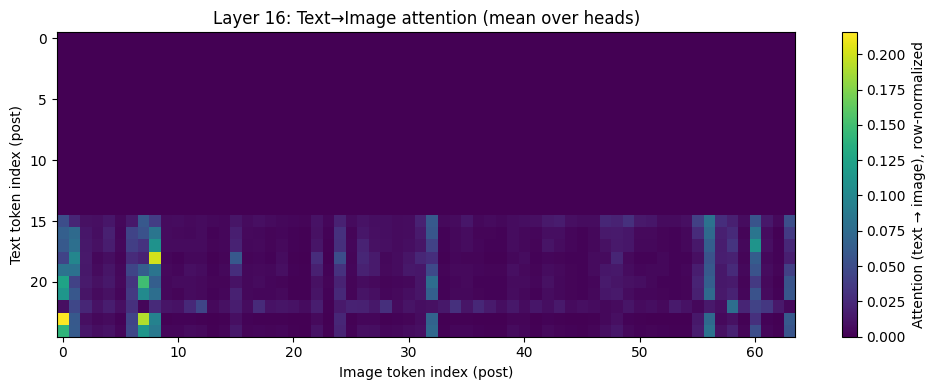

In [ ]:
layer_idx = 15  # เลือกเลเยอร์ที่สนใจ
attn_layer = attentions[layer_idx][0].mean(0)         # (T,T) เฉลี่ยหัว

# ดึงเฉพาะช่วง: query=ข้อความ, key=ภาพ
sub = attn_layer[text_idx[:,None], image_idx[None,:]].detach().cpu().float().numpy()  # shape (N_text, N_image)

# (ทางเลือก) ปรับเป็น conditional ภายในช่วงภาพ เพื่ออ่านเป็น "สัดส่วนความสนใจไปยังภาพ"
sub_norm = normalize_rows_to_subset(sub, axis_subset=1)

# เติมฉลากแกน y (ข้อความ)
labels_y = tokens_for_indices_post(text_idx, post2pre, inputs["input_ids"], processor.tokenizer)


plt.figure(figsize=(10, max(4, len(text_idx)*0.12)))
plt.imshow(sub_norm, aspect="auto")
plt.colorbar(label="Attention (text → image), row-normalized")
plt.title(f"Layer {layer_idx+1}: Text→Image attention (mean over heads)")
plt.xlabel("Image token index (post)")
plt.ylabel("Text token index (post)")
plt.tight_layout()
plt.show()

In [79]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

def collect_image_token_indices(span_info):
    # รวมช่วงภาพทั้งหมด (หลัง forward) ให้เป็นลิสต์ index (post-space)
    img_idx = []
    for s, e in span_info["spans"]:
        img_idx.extend(list(range(s, e+1)))
    return np.array(img_idx, dtype=int)

def collect_text_token_mask(span_info, post_len):
    is_visual = np.zeros(post_len, dtype=bool)
    for s, e in span_info["spans"]:
        is_visual[s:e+1] = True
    return ~is_visual, is_visual

def infer_grid_hw(n_img_tokens, img_w, img_h):
    """
    เดา (grid_h, grid_w) จากจำนวนโทเคนภาพและอัตราส่วนภาพ:
      - หาแฟกเตอร์ (h,w) ที่ h*w = n_img_tokens
      - เลือกคู่ที่ ratio h/w ใกล้กับ img_h/img_w ที่สุด
    ถ้าหาแฟกเตอร์พอดีไม่ได้ (กรณีโทเคนถูก pad/จัดรูปแปลก) จะเลือกคู่ที่ใกล้สุดจากตัวหารทั้งชุด
    """
    target_ratio = img_h / max(1e-6, img_w)
    best = None
    for h in range(1, int(np.sqrt(n_img_tokens)) + 1):
        if n_img_tokens % h == 0:
            w = n_img_tokens // h
            r = h / max(1e-6, w)
            score = abs(np.log((r+1e-12)/(target_ratio+1e-12)))
            if (best is None) or (score < best[0]):
                best = (score, h, w)
            # ลองสลับ (h,w) เผื่อ ratio อีกด้านใกล้กว่า
            r2 = w / max(1e-6, h)
            score2 = abs(np.log((r2+1e-12)/(target_ratio+1e-12)))
            if score2 < best[0]:
                best = (score2, w, h)
    if best is None:
        # fallback: สี่เหลี่ยมจัตุรัส
        side = int(np.sqrt(n_img_tokens))
        return side, max(1, n_img_tokens // max(1, side))
    _, gh, gw = best
    return gh, gw

def normalize_01(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    return (x - mn) / (mx - mn + 1e-6)

def overlay_heatmap_on_image(image_pil, heat_2d, cmap="jet", alpha=0.5, blur=2):
    heat_uint8 = (normalize_01(heat_2d) * 255).astype(np.uint8)
    att_map = Image.fromarray(heat_uint8).resize(image_pil.size, Image.BICUBIC)
    if blur and blur > 0:
        att_map = att_map.filter(ImageFilter.GaussianBlur(blur))
    plt.imshow(image_pil)
    plt.imshow(att_map, cmap=cmap, alpha=alpha)
    plt.axis("off")


LLM (Qwen2.5-VL) style — ไม่มี [CLS] จริงในลำดับมัลติโมดัล → เราสร้าง “CLS-like” โดย เฉลี่ย attention ของโทเคนข้อความทั้งหมด → ไปยังโทเคนภาพ แล้วรีเชปเป็นกริดและ overlay

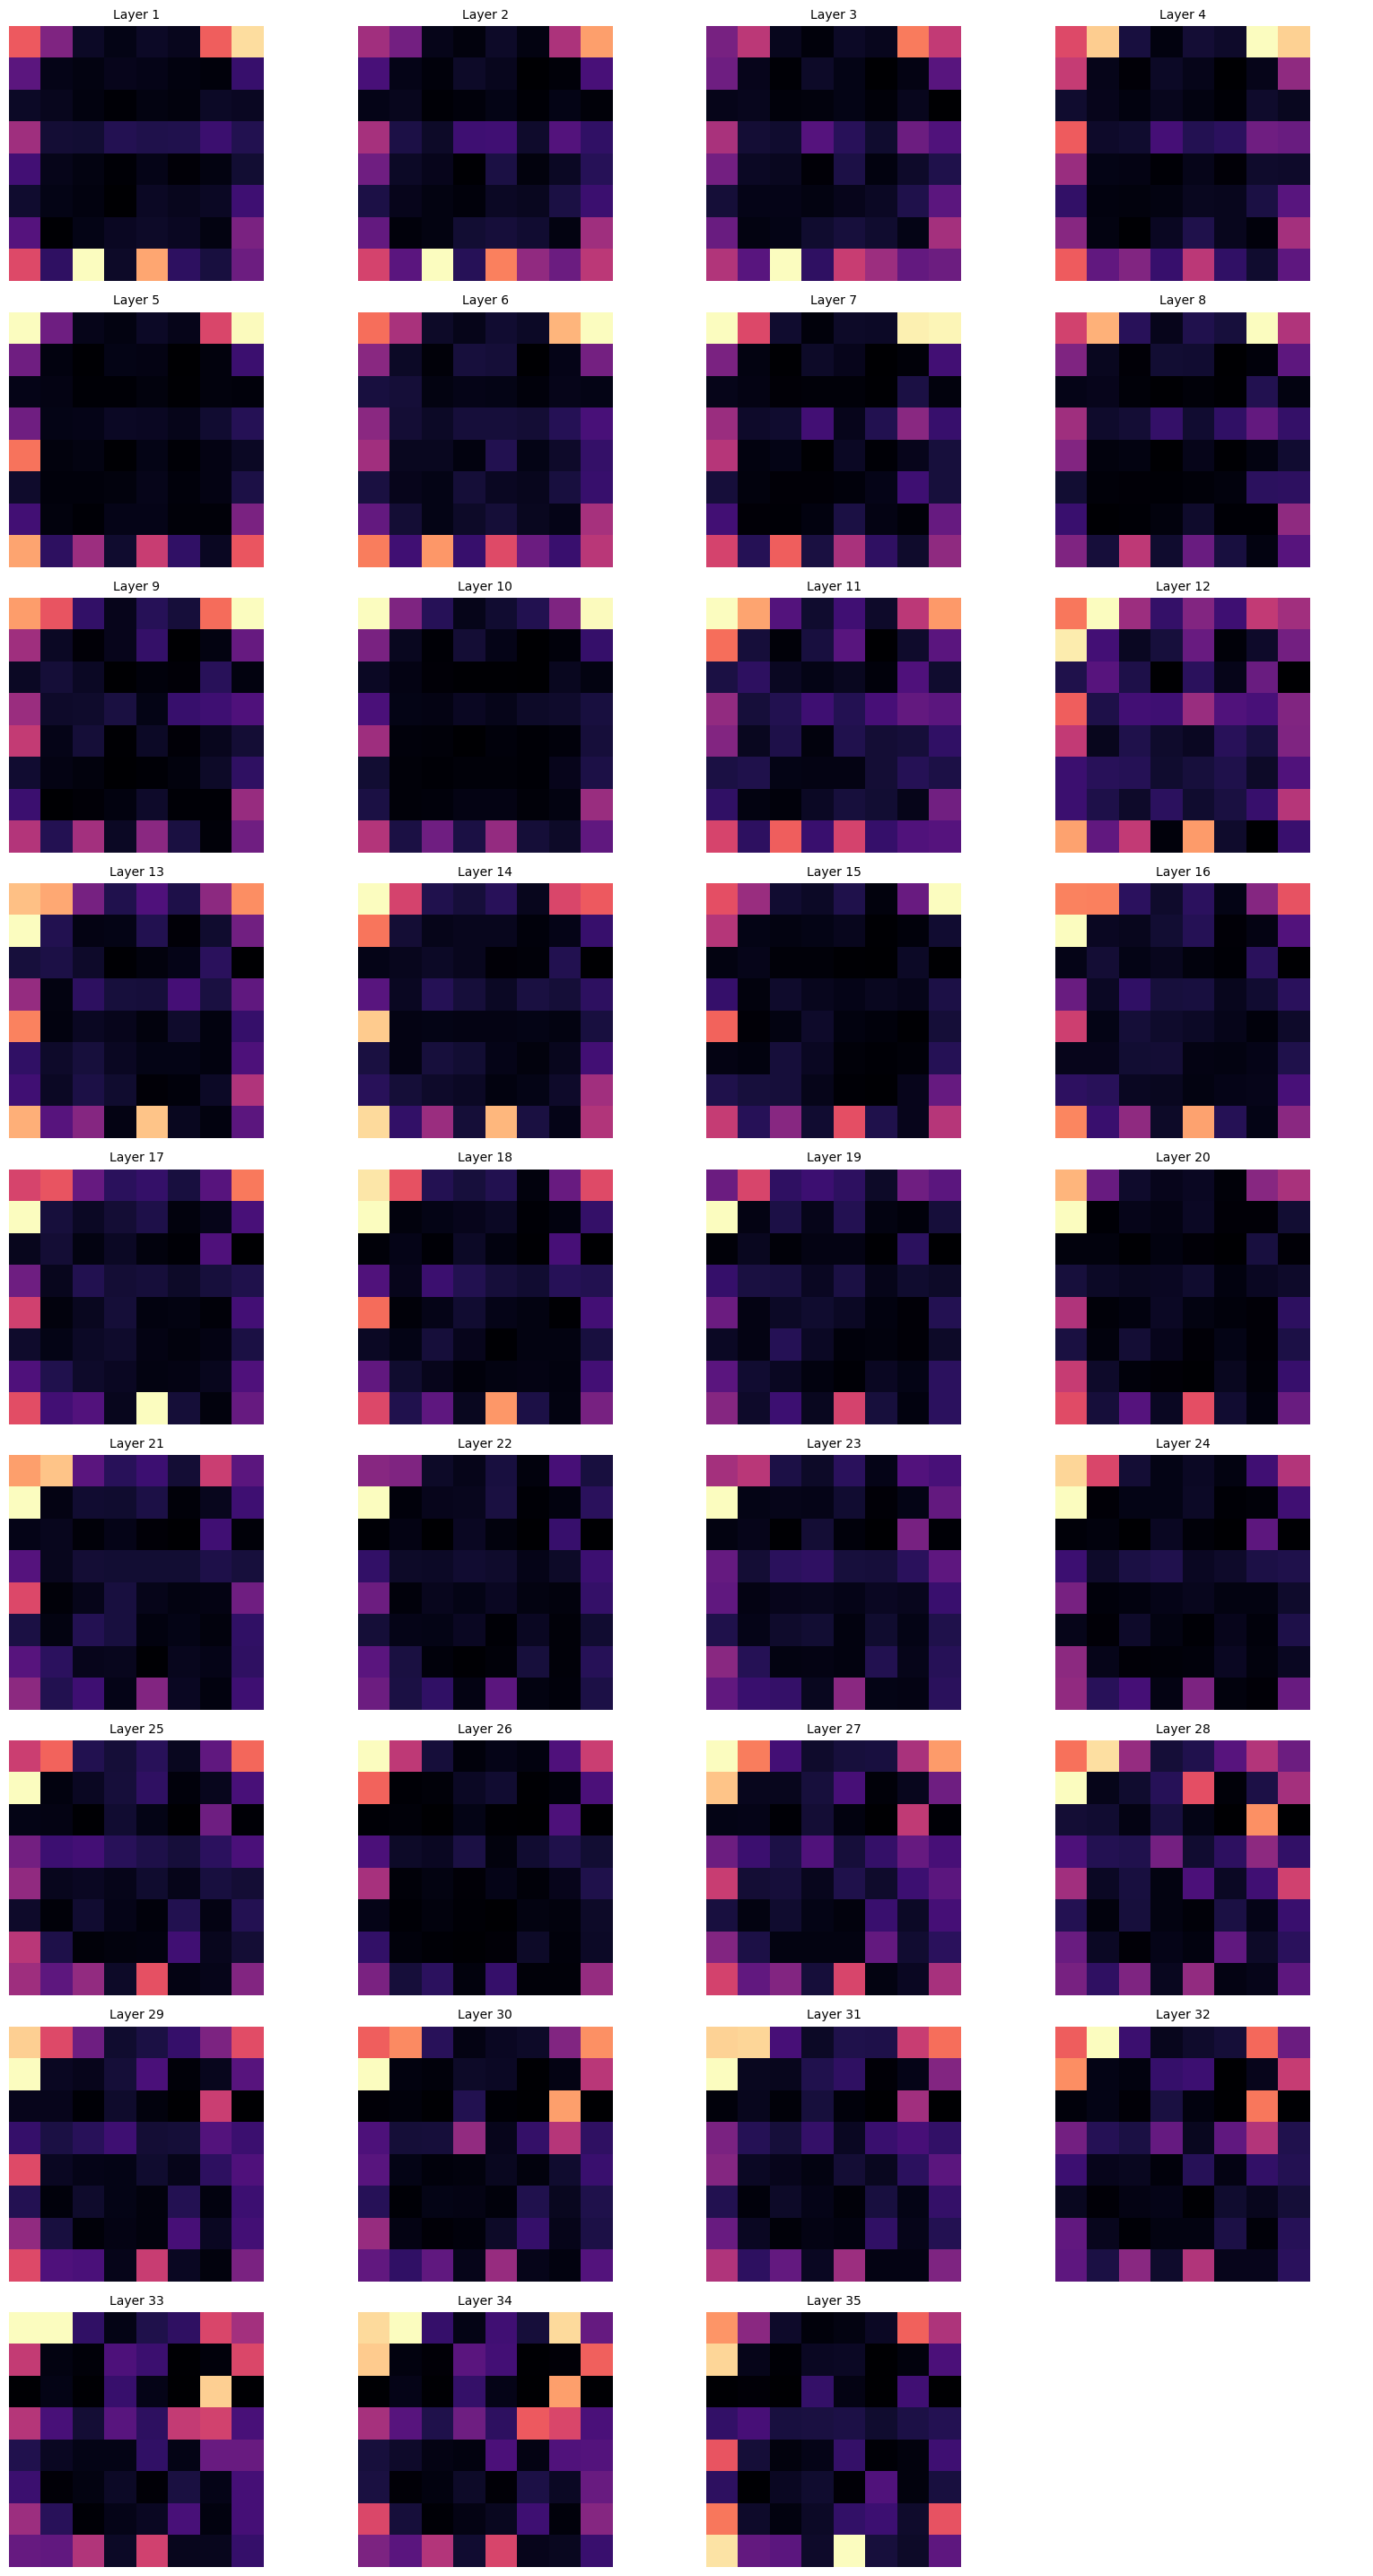

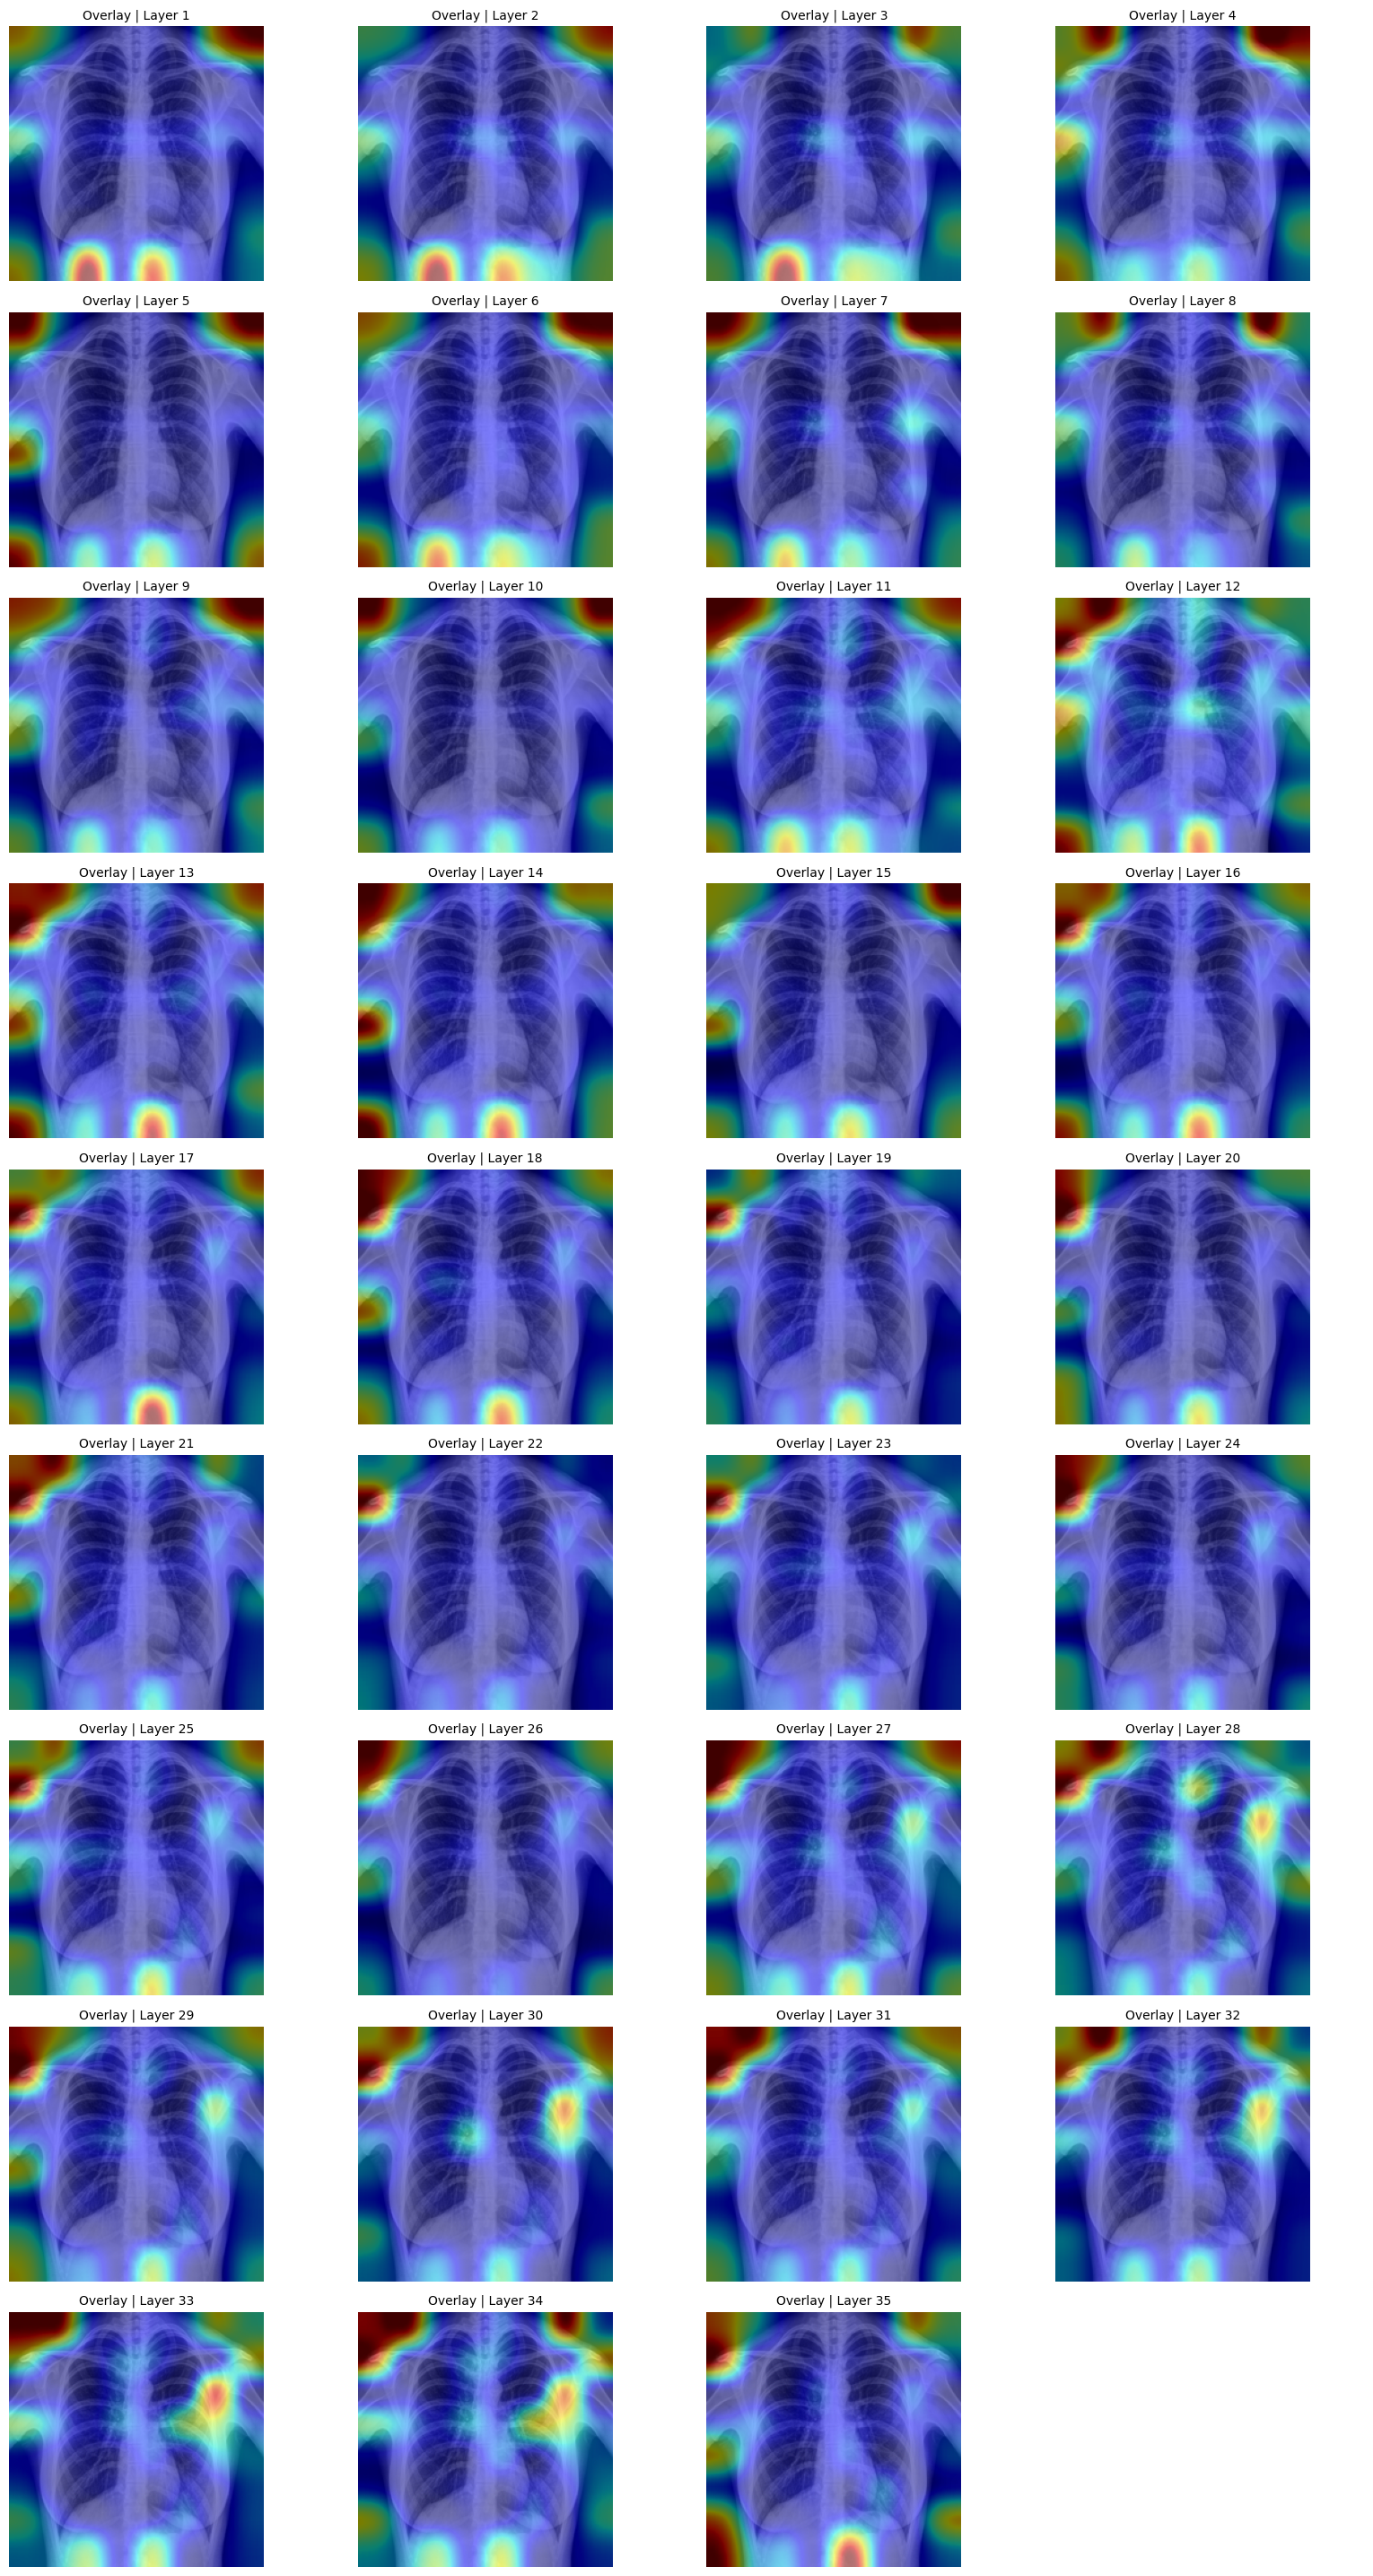

In [88]:
# ==========================================================
# 🧠 TEXT → IMAGE ATTENTION VISUALIZATION (Qwen2.5-VL Style)
# ----------------------------------------------------------
# แสดง Attention เฉลี่ยจากโทเคนข้อความทั้งหมด → โทเคนภาพ
# โดยสร้าง heatmap ของแต่ละ layer และจัดรวมเป็นตาราง (4 ภาพต่อแถว)
# จากนั้น overlay ลงบนภาพจริงเพื่อดูจุดที่โมเดล “สนใจ” บนภาพ
# ==========================================================

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import torch

# ----------------------------------------------------------
# 🔹 เตรียม index / mask สำหรับ text และ image token
# ----------------------------------------------------------
post_len = attentions[0].shape[-1]  # ความยาว sequence หลัง forward
is_text, is_visual = collect_text_token_mask(span_info, post_len)
text_idx  = np.where(is_text)[0]
image_idx = collect_image_token_indices(span_info)

# ----------------------------------------------------------
# 🔹 ฟังก์ชันคำนวณ Text→Image Rollout ต่อ Layer
# ----------------------------------------------------------
def text_to_image_rollout(attentions, layer_idx: int):
    """
    สรุป attention จากข้อความทั้งหมด → ภาพ
    1. เฉลี่ยทุกหัว (H) → (T, T)
    2. เพิ่ม self-connection (I) เพื่อคง self-loop
    3. Normalize ให้ sum ต่อแถว = 1
    4. เฉลี่ยเฉพาะ query=ข้อความ → ได้เวกเตอร์ขนาดเท่าจำนวนโทเคนทั้งหมด
    5. เลือกเฉพาะ key=โทเคนภาพ → attention ต่อภาพแต่ละตำแหน่ง
    """
    attn = attentions[layer_idx][0].mean(0)     # (T, T)
    T = attn.shape[0]
    I = torch.eye(T, dtype=attn.dtype, device=attn.device)
    A = attn + I
    A = A / (A.sum(dim=-1, keepdim=True) + 1e-6)
    vec_all_keys = A[text_idx].mean(dim=0)      # (T,)
    vec_img = vec_all_keys[image_idx]           # (N_img,)
    return vec_img.detach().cpu().float().numpy()

# ----------------------------------------------------------
# 🔹 เตรียม Heatmap สำหรับทุก Layer
# ----------------------------------------------------------
layer_idx_list = [i for i in range(35)]  # 35 layers
img_w, img_h = image.size
n_img_tokens = len(image_idx)
grid_h, grid_w = infer_grid_hw(n_img_tokens, img_w, img_h)

heats = []
for i in layer_idx_list:
    vec_img = text_to_image_rollout(attentions, i)  # (N_img,)
    heat = vec_img.reshape(grid_h, grid_w)
    heat = normalize_01(heat)
    heats.append((i, heat))

# ----------------------------------------------------------
# 🔹 วาดรวม Heatmap ของทุก Layer (4 ภาพต่อแถว)
# ----------------------------------------------------------
ncols = 4
nrows = math.ceil(len(heats) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
axs = axs.flatten()

vmin, vmax = 0.0, 1.0  # scale สีเดียวกันทุกภาพ

for ax, (i, heat) in zip(axs, heats):
    ax.imshow(heat, cmap="magma", interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_title(f"Layer {i+1}", fontsize=10)
    ax.axis("off")

# ปิดช่องว่างถ้า layer ไม่ครบช่อง
for ax in axs[len(heats):]:
    ax.axis("off")

# ✅ ไม่ต้องใส่ colorbar แยก (ปิดแกนสี CLS)
# plt.suptitle("Text→Image Attention Heatmaps (mean over heads)", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 🔹 ฟังก์ชัน Overlay Heatmap ลงบนภาพจริง (ใช้ในตารางต่อไป)
# ----------------------------------------------------------
def overlay_heatmap_on_axis(ax, image_pil, heat_2d, cmap="jet", alpha=0.5, blur=2):
    """แสดงภาพ overlay ของ attention heatmap ลงบนภาพต้นฉบับ"""
    heat_uint8 = (normalize_01(heat_2d) * 255).astype(np.uint8)
    att_map = Image.fromarray(heat_uint8).resize(image_pil.size, Image.BICUBIC)
    if blur and blur > 0:
        att_map = att_map.filter(ImageFilter.GaussianBlur(blur))
    ax.imshow(image_pil)
    ax.imshow(att_map, cmap=cmap, alpha=alpha)
    ax.axis("off")

# ----------------------------------------------------------
# 🔹 วาด Overlay รวม (4 ภาพต่อแถว)
# ----------------------------------------------------------
ncols = 4
nrows = math.ceil(len(heats) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
axs = axs.flatten()

for ax, (i, heat) in zip(axs, heats):
    overlay_heatmap_on_axis(ax, image, heat, cmap="jet", alpha=0.5, blur=2)
    ax.set_title(f"Overlay | Layer {i+1}", fontsize=10)

for ax in axs[len(heats):]:
    ax.axis("off")

# plt.suptitle("Text→Image Attention Overlay (4 per row)", fontsize=14)
plt.tight_layout()
plt.show()

### Visualize Activation ของ Dense Layer

In [89]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_hidden_states=True,   # <— สำคัญ
        return_dict=True,
        use_cache=False
    )

hidden_states = out.hidden_states
# print(type(hidden_states))
# print(len(hidden_states))
# print(hidden_states)

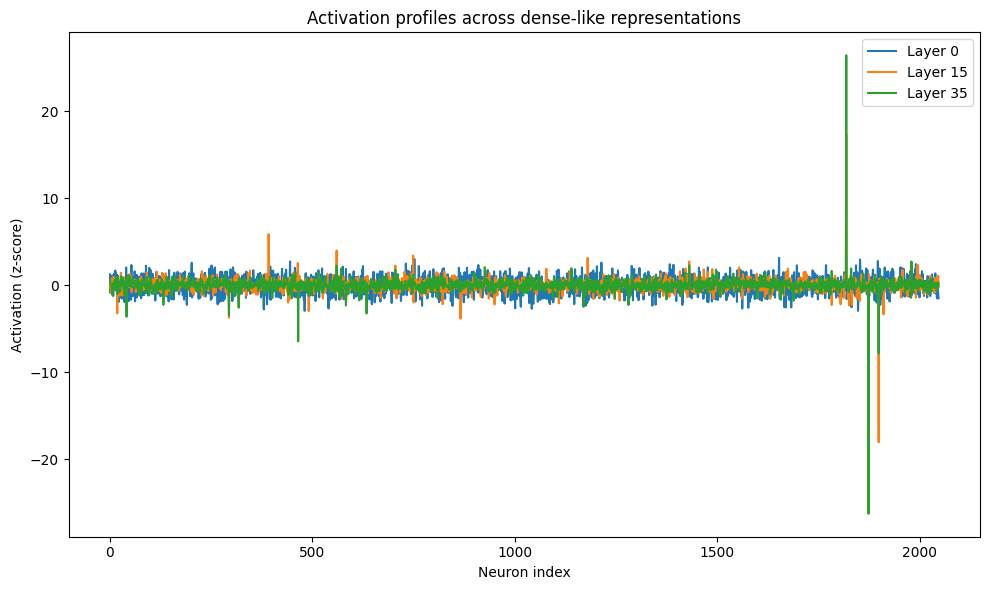

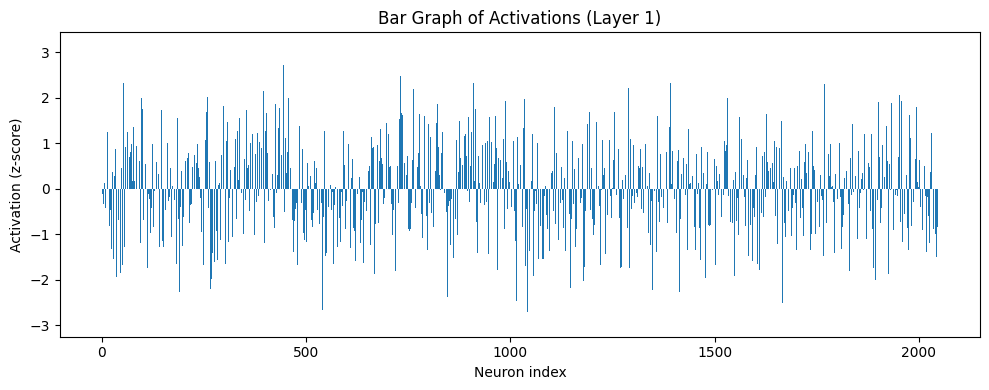

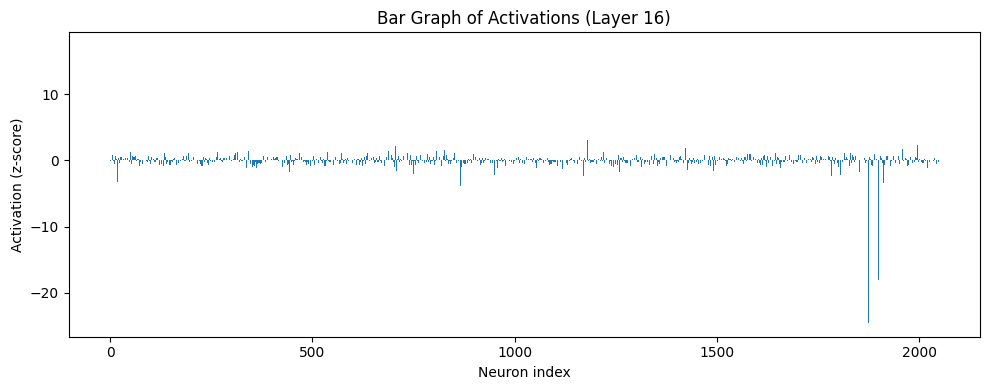

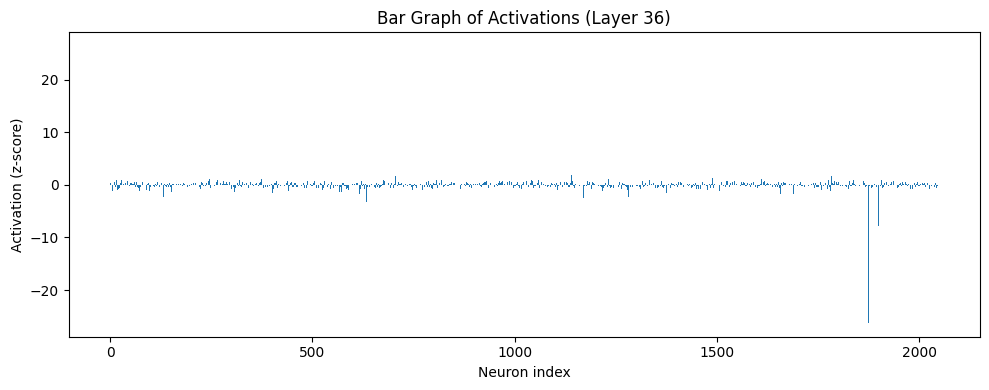

In [90]:
layers_to_show = [0, 15, 35]  # ตัวอย่าง 3 เลเยอร์
plt.figure(figsize=(10, 6))

for k, li in enumerate(layers_to_show, 1):
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    plt.plot(v, label=f"Layer {li}")

plt.title("Activation profiles across dense-like representations")
plt.xlabel("Neuron index")
plt.ylabel("Activation (z-score)")
plt.legend()
plt.tight_layout()
plt.savefig(f"Activation profiles across dense-like representations.png", dpi=300, bbox_inches="tight")
plt.show()

for li in layers_to_show:
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(v)), v)
    plt.title(f"Bar Graph of Activations (Layer {li + 1})")
    plt.xlabel("Neuron index")
    plt.ylabel("Activation (z-score)")
    plt.tight_layout()
    plt.savefig(f"Bar Graph of Activations Layer {li + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()